# Sentiment Detection in Bangla Text: Building and Analyzing a Multimodal Dataset for Emotion Classification

Emotions are an integral part of human communication, influencing the way we express ourselves and perceive others' messages. In the digital age, the proliferation of social media, online reviews, and text-based communication platforms has led to a massive influx of textual data that encapsulates a diverse range of sentiments. Understanding and accurately categorizing these sentiments, such as happiness, anger, fear, disgust, sadness, and surprise, is not only crucial for improving natural language processing systems but also for gaining insights into human behavior and opinion dynamics.

This thesis project delves into the realm of sentiment analysis for the Bangla language, a significant and vibrant language spoken by millions of people. The objective of this project is to create a comprehensive Bangla sentiment detection dataset encompassing various emotions, allowing for robust sentiment analysis. The dataset's multilingual nature and focus on diverse emotions make it an invaluable resource for researchers, enabling the development of more nuanced and culturally sensitive sentiment classification models.

# Objectives:

# Dataset Construction: 
The first phase of the project involves meticulously curating a diverse and representative dataset that captures different sentiment categories. This dataset encompasses a wide array of Bangla texts, including social media posts, product reviews, and literary excerpts, ensuring the inclusion of both informal and formal language styles.

# Annotation and Categorization: 
The collected dataset will be annotated by human experts proficient in Bangla language and culture. Each text will be categorized into one of the predefined sentiment categories: happy, angry, fear, disgust, sad, or surprise. This categorization will be the foundation for training and evaluating sentiment classification models.

# Model Development: 
The project aims to develop state-of-the-art sentiment classification models specifically tailored for the Bangla language. Leveraging the annotated dataset, these models will employ advanced natural language processing techniques, potentially including pre-trained language embeddings and neural network architectures.

# Performance Evaluation: 
The developed sentiment classification models will undergo rigorous evaluation using various metrics to assess their accuracy, precision, recall, and F1-score. The goal is to create models that not only accurately predict sentiment but also generalize well to real-world Bangla text data.

# Cultural Nuances: 
A significant aspect of this project involves addressing cultural nuances and linguistic intricacies unique to the Bangla language. By developing models that can account for these factors, the sentiment analysis becomes more culturally sensitive and contextually relevant.

# Applications and Implications: 
The outcome of this project extends beyond academic research, with potential applications in various fields, including social media monitoring, market analysis, and customer feedback evaluation. Additionally, insights gained from the analysis of Bangla sentiments can contribute to cross-cultural studies of emotion expression and perception.


# Import Library

In [2]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
from itertools import chain


# Dataset Load

In [10]:
file_path = 'corpus_all.txt'  # Replace with the actual path to your text file

lines = []  # Empty list to store the lines

try:
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            lines.append(line.strip())  # Append the line to the list, removing any leading/trailing whitespace

except FileNotFoundError:
    print("File not found. Please check the file path and try again.")
    
#file_path = 'corpus_all.txt'  # Replace with the actual path to your text file
first_words = []  # Empty list to store the first words

try:
    for line in lines:
        words = line.strip().split()  # Split the line into words
        if words:
            first_word = words[0]  # Get the first word
            first_words.append(first_word)  # Append the first word to the list

except FileNotFoundError:
    print("File not found. Please check the file path and try again.")

# Define the status levels
status_levels = ["happy","angry","fear","disgust","sad","surprise"]

# Initialize a list to store the extracted status levels and sentences
extracted_data = []

# Iterate over the texts
for text in lines:
    # Initialize variables to store the extracted status level and sentence
    status = ""
    sentence = ""

    # Iterate over the status levels
    for level in status_levels:
        if level in text:
            # Split the text based on the status level
            split_text = text.split(level, 1)

            # Extract the status level and sentence
            status = level
            sentence = split_text[1].strip()
            break

    # Append the extracted status level and sentence to the list
    extracted_data.append({"Status": status, "Sentence": sentence})
    
data = pd.DataFrame(extracted_data)

# Some Data From Dataset

In [11]:
data

,Status,Sentence
0,sad,"বরাবর, মাননীয় প্রধানমন্ত্রী গণপ্রজাতন্ত্রী বা..."
1,sad,তদন্ত করে লাভ কী ? কোন দিন কোন তদন্তের পর কিছু...
2,angry,দেশকি মধ্যম আয়ের দেশে রুপান্তর হচ্ছে নাকি মগের...
3,happy,আমি গর্বিত আমি মুসলিম। আমি সংগ্রামী। আমি যোদ্ধ...
4,angry,রাতের বেলা আবার কিসের সকাল।
...,...,...
6284,surprise,ভারতে প্রতিদিন ১৮ টা রেপ কেইস এন্ট্রি হয়
6285,surprise,এই কি স্বাধীন দেশ
6286,sad,স্বাধীন দেশের নাগরিক হয়ে ও আজ আমরা পরাধীন।
6287,angry,চুদলাম দাদা পয়সা নাই


In [12]:
# Dataset Shape

In [13]:
data.shape

(6289, 2)

# Dataset Status Count Value

In [14]:
data['Status'].value_counts()

happy       1905
angry       1410
sad         1331
disgust      698
surprise     562
fear         383
Name: Status, dtype: int64

# Status Count Show By Bar Chart

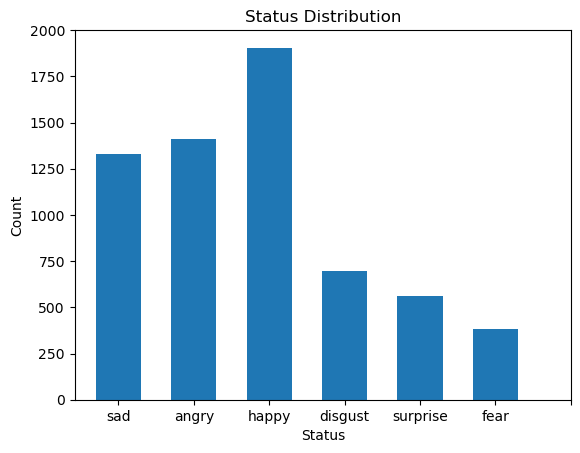

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.hist(data['Status'], bins=[0, 1, 2, 3, 4, 5, 6], align='left', rwidth=0.6)
plt.xticks([0, 1, 2, 3, 4, 5, 6])
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Status Distribution')
plt.show()

In [17]:

# Separate sentences and sentiments
sentences = data['Sentence'].values
sentiments = data['Status'].values

# Map sentiment labels to numerical values
sentiment_mapping = {'happy': 0, 'angry': 1, 'fear': 2, 'disgust': 3, 'sad': 4, 'surprise': 5}
sentiments = [sentiment_mapping[s] for s in sentiments]

# Split the data into training and testing sets
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, sentiments, test_size=0.2, random_state=42)


In [18]:

# Set the maximum number of words to keep in the vocabulary
max_words = 5000

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(sentences_train)

# Convert sentences to sequences of integers
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences to ensure they have the same length
max_sequence_length = max(len(seq) for seq in X_train)
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

# Convert sentiment labels to one-hot encoded vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [19]:
print(y_train.shape,y_test.shape)

(5031, 6) (1258, 6)


In [29]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Define the LSTM model
embedding_dim = 100
lstm_units = 64

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=lstm_units))
model.add(Dense(units=6, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [30]:
# Train the model
batch_size = 32
epochs = 5

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/5
142/142 [==============================] - 126s 861ms/step - loss: 1.5906 - accuracy: 0.3567 - val_loss: 1.4586 - val_accuracy: 0.4325
Epoch 2/5
142/142 [==============================] - 121s 849ms/step - loss: 1.2648 - accuracy: 0.5273 - val_loss: 1.3796 - val_accuracy: 0.4643
Epoch 3/5
142/142 [==============================] - 120s 843ms/step - loss: 0.9688 - accuracy: 0.6468 - val_loss: 1.4858 - val_accuracy: 0.4325
Epoch 4/5
142/142 [==============================] - 147s 1s/step - loss: 0.7238 - accuracy: 0.7548 - val_loss: 1.7221 - val_accuracy: 0.4286
Epoch 5/5
142/142 [==============================] - 142s 999ms/step - loss: 0.5134 - accuracy: 0.8306 - val_loss: 2.0388 - val_accuracy: 0.4187


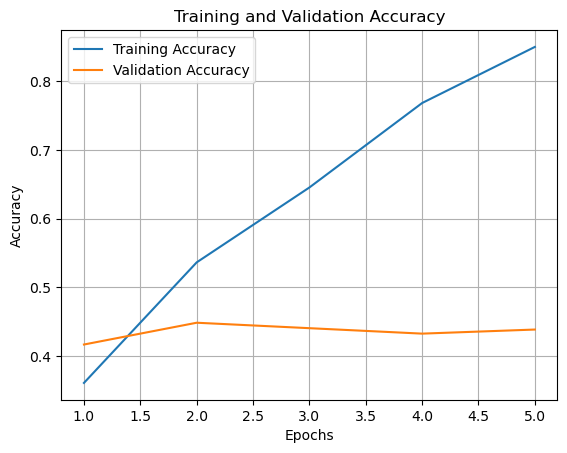

In [22]:
# Get the training and validation accuracy history from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a plot for training and validation accuracy
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# ... (your existing code up to training the model) ...

# Generate predictions using the trained model
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded labels to class labels for y_test
y_test_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Accuracy: {accuracy}")

# Print the confusion matrix
print("Confusion Matrix:")
print(classification_report(y_test_classes, y_pred_classes))



40/40 [==============================] - 21s 490ms/step
Accuracy: 0.44753577106518283
Confusion Matrix:
              precision    recall  f1-score   support

           0       0.66      0.76      0.71       391
           1       0.42      0.43      0.42       268
           2       0.07      0.05      0.06        66
           3       0.17      0.15      0.16       141
           4       0.42      0.35      0.38       278
           5       0.22      0.24      0.23       114

    accuracy                           0.45      1258
   macro avg       0.32      0.33      0.33      1258
weighted avg       0.43      0.45      0.44      1258



40/40 [==============================] - 20s 501ms/step


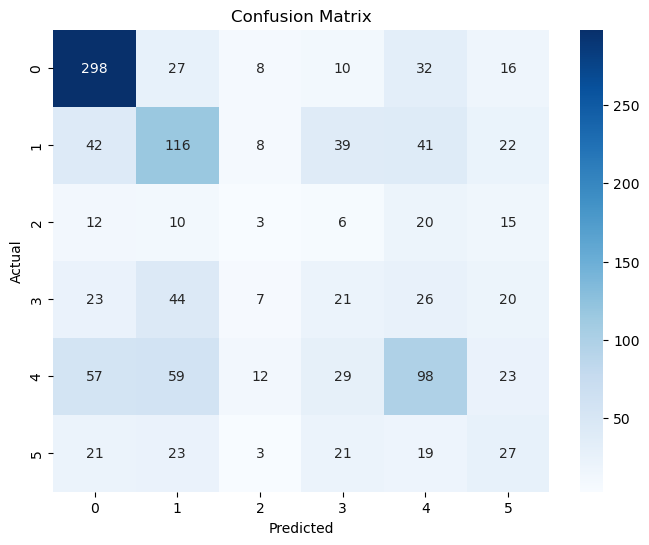

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate predictions using the trained model
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded labels to class labels for y_test
y_test_classes = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Get class labels (assuming classes are 0, 1, 2, ...)
class_labels = np.arange(len(cm))

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

sentiment_mapping = {0: 'Simple', 1: 'Compound', 2: 'Complex'}

# Generate predictions using the trained model
y_pred_probs = model.predict(X_test)

# Assuming you have multi-class labels (not one-hot encoded)
y_test_classes = np.argmax(y_test, axis=1)

# Compute ROC curve and AUC for each class using "One vs Rest"
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_name in sentiment_mapping.items():
    class_index = i  # Use the class index (0, 1, 2)
    fpr[i], tpr[i], _ = roc_curve(y_test_classes == class_index, y_pred_probs[:, class_index])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i, class_name in sentiment_mapping.items():
    plt.plot(fpr[i], tpr[i], label=f'Class {class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend(loc='lower right')
plt.show()
